<a href="https://colab.research.google.com/github/KrajShuffle/ML_Audio_Models/blob/main/Sep_Audio_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 13.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing
import os
from tqdm import tqdm
import librosa
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive') # Allows connection to google drive for credentials

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/AWS_Alcohol_Tenvos
%pwd

/content/drive/MyDrive/AWS_Alcohol_Tenvos


'/content/drive/MyDrive/AWS_Alcohol_Tenvos'

### Loading Train, Val, Test Dataset & Labels

In [5]:
def load_ds_labels(ds_name):
  """ Options include "train", "val", "test" & Code for Labels -> {"I" : 0, "S" : 1}
  """
  arr_ds_specs = np.load(ds_name + "_spectrogram_data.npy")
  print(arr_ds_specs.shape)
  df_ds_mapping = pd.read_csv(ds_name + "_class_wav.csv", index_col = 0)
  df_ds_mapping['y_label'] = df_ds_mapping["Imp_Sob"].apply(lambda x: 0 if x == "I" else 1)
  y_labels = df_ds_mapping['y_label'].values
  return arr_ds_specs, df_ds_mapping, y_labels

In [6]:
dict_labels = {'I' : 0, "S" : 1}
dict_labels

{'I': 0, 'S': 1}

In [7]:
arr_train_specs, df_train_mapping, train_y = load_ds_labels("train")
df_train_mapping

(4650, 128, 300)


,Array_Pos,Filename,Session,Time_sec,Imp_Sob,y_label
0,0,0171017001_h_00.wav,ses1017,7.94,I,0
1,1,0171017015_h_00.wav,ses1017,5.73,I,0
2,2,0171017030_h_00.wav,ses1017,6.51,I,0
3,3,0171017016_h_00.wav,ses1017,6.64,I,0
4,4,0171017002_h_00.wav,ses1017,61.20,I,0
...,...,...,...,...,...,...
4645,4645,5323033011_h_00.wav,ses3033,6.94,I,0
4646,4646,5323033014_h_00.wav,ses3033,11.46,I,0
4647,4647,5323033012_h_00.wav,ses3033,11.44,I,0
4648,4648,5323033015_h_00.wav,ses3033,6.42,I,0


In [8]:
print(len(train_y))
train_y

4650


array([0, 0, 0, ..., 0, 0, 0])

In [9]:
arr_val_specs, df_val_mapping, val_y = load_ds_labels("val")
df_val_mapping

(3510, 128, 300)


,Array_Pos,Filename,Session,Imp_Sob,y_label
0,0,0261027001_h_01.wav,ses1027,I,0
1,1,0261027016_h_00.wav,ses1027,I,0
2,2,0261027002_h_00.wav,ses1027,I,0
3,3,0261027017_h_00.wav,ses1027,I,0
4,4,0261027003_h_00.wav,ses1027,I,0
...,...,...,...,...,...
3505,3505,5964080013_h_00.wav,ses4080,S,1
3506,3506,5964080010_h_00.wav,ses4080,S,1
3507,3507,5964080014_h_00.wav,ses4080,S,1
3508,3508,5964080011_h_00.wav,ses4080,S,1


In [10]:
print(len(val_y))
val_y

3510


array([0, 0, 0, ..., 1, 1, 1])

In [11]:
arr_test_specs, df_test_mapping, test_y = load_ds_labels("test")
df_test_mapping

(3870, 128, 300)


,Array_Pos,Filename,Session,Imp_Sob,y_label
0,0,0151015001_h_00.wav,ses1015,I,0
1,1,0151015002_h_00.wav,ses1015,I,0
2,2,0151015003_h_00.wav,ses1015,I,0
3,3,0151015004_h_00.wav,ses1015,I,0
4,4,0151015005_h_00.wav,ses1015,I,0
...,...,...,...,...,...
3865,3865,5824078019_h_00.wav,ses4078,S,1
3866,3866,5824078050_h_00.wav,ses4078,S,1
3867,3867,5824078051_h_00.wav,ses4078,S,1
3868,3868,5824078020_h_00.wav,ses4078,S,1


In [12]:
print(len(test_y))
test_y

3870


array([0, 0, 0, ..., 1, 1, 1])

In [13]:
# Trialing data transform function
fnc_reshape = lambda x: x.reshape(x.shape[0], 1 , x.shape[1], x.shape[2])
reshaped_X_train = fnc_reshape(arr_train_specs)
reshaped_X_train.shape

(4650, 1, 128, 300)

### Defining DataLoader Class with Weighted Random Sampler to account for Class Imbalance

In [14]:
from torch.utils.data import Dataset

class Audio_DS(Dataset):
    def __init__(self, data, labels, device = "cuda", transform=lambda x: x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])):
        # Initialize dataset here
        self.transform = transform # Dataset Transformation
        self.data = self.transform(data) # Loading in reshaped numpy dataset
        self.labels = labels
        self.device = device

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data[idx]
      label = self.labels[idx]

      # Memory Efficient way of storing tensors to GPU and assigning dtype
      sample = torch.tensor(sample, dtype=torch.float).to(self.device)
      label = torch.tensor(label, dtype=torch.int64).to(self.device)

      return sample, label

### Model Definition

In [15]:
import torch
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 5,kernel_size = 4, stride = 1, padding= 2),
                                   nn.Conv2d(in_channels= 5, out_channels= 7,kernel_size = 3, stride = 1, padding= 1)])
        self.bn = nn.ModuleList([nn.BatchNorm2d(5), nn.BatchNorm2d(7)])
        self.fc = nn.ModuleList([nn.Linear(1008, 504), nn.Linear(504, 2)])
        self.pooling = nn.AvgPool2d(kernel_size = 4)
        self.activation = nn.ReLU()

    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten() (x)
        for i in range(len(self.fc)):
          x = self.fc[i](x)
        return x

In [16]:
from torchsummary import summary
# Specify the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CNN().to(device)

# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(model, (1,128,300))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 129, 301]              85
       BatchNorm2d-2          [-1, 5, 129, 301]              10
              ReLU-3          [-1, 5, 129, 301]               0
         AvgPool2d-4            [-1, 5, 32, 75]               0
            Conv2d-5            [-1, 7, 32, 75]             322
       BatchNorm2d-6            [-1, 7, 32, 75]              14
              ReLU-7            [-1, 7, 32, 75]               0
         AvgPool2d-8             [-1, 7, 8, 18]               0
            Linear-9                  [-1, 504]         508,536
           Linear-10                    [-1, 2]           1,010
Total params: 509,977
Trainable params: 509,977
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 4.93
Params size (MB): 1.95
Estima

In [17]:
from torch.utils.tensorboard import SummaryWriter
cnn_logger = SummaryWriter(log_dir = 'CNN_Audio_Balanced')

### **Class for Training, Validation, & Testing Network**

In [18]:
# Defining function for timing model training
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [24]:
import torch
from torch.optim import Adam
import torchmetrics
from torchmetrics.classification import BinaryF1Score
from torch.utils.data import DataLoader, WeightedRandomSampler
class Trainer():
  def __init__(self, model, epochs, learning_rate, batch_size, device = "cuda", optimizer_type = "Adam"):
    self.model = model.to(device)
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.device = device
    if optimizer_type == "Adam":
      self.optimizer = Adam(model.parameters(), learning_rate)
    self.f1 = BinaryF1Score().to(device)

  @timing
  def train(self, train_ds, val_ds, sampler, early_stop = True, L2 = True, tens_logger = None, L2_reg = 1e-5):

    # Initialize lists to store metrics, initial weights of model, way to record val_loss to do early stopping,

    losses = []
    accs = []
    f1s = []
    val_losses = []
    val_accs = []
    val_f1s = []
    weights = self.model.state_dict()
    lowest_val_loss = np.inf

    # Loading in the train dataset
    train_dataloader = DataLoader(train_ds, self.batch_size, sampler = sampler)

    for n_epoch in range(self.epochs):
      # Initializing the metrics for each epoch to be 0
      epoch_loss = 0
      epoch_acc = 0
      epoch_f1 = 0
      for batch, acc_labels in train_dataloader:
        prop_ds = len(batch) / len(train_ds) # Track proportion of dataset used in batch for scaling metrics per batch size
        self.optimizer.zero_grad()       # Setting gradients to 0 prior to backpropagating loss
        batch_logits = self.model(batch) # Generate logits for batch
        loss = nn.CrossEntropyLoss() (batch_logits, acc_labels)
        if L2:
          loss = loss + L2_reg * sum([(wei ** 2).sum() for wei in self.model.parameters()])
        loss.backward()
        self.optimizer.step()
        batch_preds = torch.argmax(batch_logits, axis = -1)

        # Compute Metrics for each batch and store as running sum for each epoch
        epoch_loss += loss.detach().item() * prop_ds
        acc = sum(batch_preds == acc_labels) / len(acc_labels)
        epoch_acc += acc.detach().item() * prop_ds
        batch_f1 = self.f1(torch.argmax(batch_logits, axis = -1), acc_labels).detach().item()
        epoch_f1 += batch_f1 * prop_ds

      # Run Validation call for each epoch
      val_loss, val_acc, val_f1 = self.evaluate(val_ds)

      # Add each epoch metric to list
      losses.append(epoch_loss)
      accs.append(epoch_acc)
      f1s.append(epoch_f1)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      val_f1s.append(val_f1)

      # Print Results for Each Epoch
      print("Epoch %d/%d - Loss: %.3f - Train_Acc: %.3f - Train_F1: %.3f" % (n_epoch + 1, self.epochs, epoch_loss, epoch_acc, epoch_f1))
      print("              Val_loss: %.3f - Val_Acc: %.3f - Val_F1: %.3f" % (val_loss, val_acc, val_f1))

      # Early Stop Check for Each Epoch
      if early_stop:
        if val_loss < lowest_val_loss:
          lowest_val_loss = val_loss
          weights = self.model.state_dict()
      # Tensorboard Metric Tracking
      if tens_logger is not None:
                tens_logger.add_scalar("Train Loss", epoch_loss, n_epoch + 1)
                tens_logger.add_scalar("Train Accuracy", epoch_acc, n_epoch + 1)
                tens_logger.add_scalar("Train F1", epoch_f1, n_epoch + 1)
                tens_logger.add_scalar("Val Loss", val_loss, n_epoch + 1)
                tens_logger.add_scalar("Val Acc", val_acc, n_epoch + 1)
                tens_logger.add_scalar("Val F1", val_f1, n_epoch + 1)
    # After all epochs
    if early_stop:
      self.model.load_state_dict(weights)
    return {"model": self.model, "train_accs" : accs, "train_losses" : losses,"train_f1s" : f1s,
            "val_accs" : val_accs, "val_losses" : val_losses, "val_f1s" : val_f1s}

  def evaluate(self, val_dset, val = True):
    # Initialize metrics & dataloader for validation dataset
    ep_loss = 0
    ep_acc = 0
    ep_f1 = 0
    all_preds = []
    all_labels = []
    val_data_loader = DataLoader(val_dset, self.batch_size, shuffle = True)
    for batch, acc_labels in val_data_loader:
      prop_ds = len(batch) / len(val_dset)
      with torch.no_grad():
        batch_logits = self.model(batch)
        loss = nn.CrossEntropyLoss()(batch_logits, acc_labels)
        batch_preds = torch.argmax(batch_logits, axis = -1)
      # Update Epoch Metrics for each batch
      ep_loss += loss.detach().item() * prop_ds
      acc = torch.sum(batch_preds == acc_labels) / len(acc_labels)
      ep_acc += acc.detach().item() * prop_ds
      batch_f1 = self.f1(torch.argmax(batch_logits, axis = -1), acc_labels).detach().item()
      ep_f1 += batch_f1 * prop_ds
      if val == False:
        all_preds.extend(batch_preds.tolist())
        all_labels.extend(acc_labels.tolist())
   # After entire epoch, depending on this is a validation run or testing dataset run
    if val == False:
      print("Test Accuracy: %.3f" % ep_acc)
      print("Test F1: %.3f" % ep_f1)
      return all_preds, all_labels

    return ep_loss, ep_acc, ep_f1


In [20]:
# Instantiating Dataset classes for Single Sample: Train & Val
train_ds = Audio_DS(arr_train_specs, train_y, device= "cuda")
val_ds = Audio_DS(arr_val_specs, val_y, device = "cuda")

In [22]:
from torch.utils.data import WeightedRandomSampler
# Calculating sample weights based on inverse class frequencies
counts_series = df_train_mapping['Imp_Sob'].value_counts()
class_counts = counts_series.values  # Replace with actual class frequencies
sample_weights = [1 / counts_series.loc[class_val] for class_val in df_train_mapping['Imp_Sob']]

# Instantiating WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

In [27]:
num_eps = 27
lr = 1e-3
batch_sz = 32
cnn = CNN()
mlp_trainer = Trainer(cnn, num_eps, lr, batch_sz, device = "cuda", optimizer_type= "Adam")
train_val_dict = mlp_trainer.train(train_ds, val_ds, sampler, early_stop = True, L2 = True,
                                   tens_logger= cnn_logger)

Epoch 1/27 - Loss: 0.732 - Train_Acc: 0.559 - Train_F1: 0.496
              Val_loss: 0.728 - Val_Acc: 0.502 - Val_F1: 0.559
Epoch 2/27 - Loss: 0.665 - Train_Acc: 0.599 - Train_F1: 0.549
              Val_loss: 0.562 - Val_Acc: 0.748 - Val_F1: 0.849
Epoch 3/27 - Loss: 0.650 - Train_Acc: 0.612 - Train_F1: 0.566
              Val_loss: 0.657 - Val_Acc: 0.619 - Val_F1: 0.716
Epoch 4/27 - Loss: 0.633 - Train_Acc: 0.643 - Train_F1: 0.626
              Val_loss: 0.722 - Val_Acc: 0.547 - Val_F1: 0.626
Epoch 5/27 - Loss: 0.605 - Train_Acc: 0.668 - Train_F1: 0.657
              Val_loss: 0.719 - Val_Acc: 0.576 - Val_F1: 0.663
Epoch 6/27 - Loss: 0.604 - Train_Acc: 0.672 - Train_F1: 0.666
              Val_loss: 0.591 - Val_Acc: 0.700 - Val_F1: 0.802
Epoch 7/27 - Loss: 0.587 - Train_Acc: 0.689 - Train_F1: 0.682
              Val_loss: 0.582 - Val_Acc: 0.736 - Val_F1: 0.837
Epoch 8/27 - Loss: 0.575 - Train_Acc: 0.703 - Train_F1: 0.692
              Val_loss: 0.760 - Val_Acc: 0.531 - Val_F1: 0.604


### **Model Performance on Train & Validation Sets**

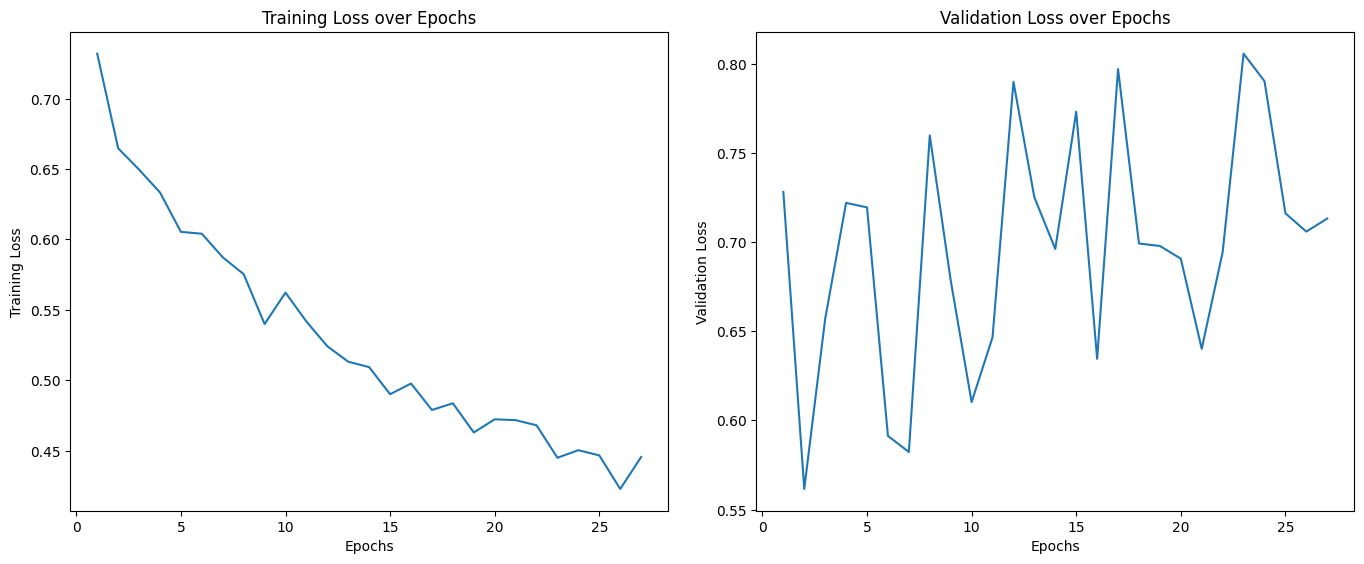

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Training Res on Left
axs[0].plot(range(1, num_eps + 1), train_val_dict['train_losses'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Training Loss")
axs[0].set_title("Training Loss over Epochs");
axs[0].set
# Plotting Validation Res on Right
axs[1].plot(range(1, num_eps + 1), train_val_dict['val_losses'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Validation Loss")
axs[1].set_title("Validation Loss over Epochs");
fig.tight_layout(pad = 2);

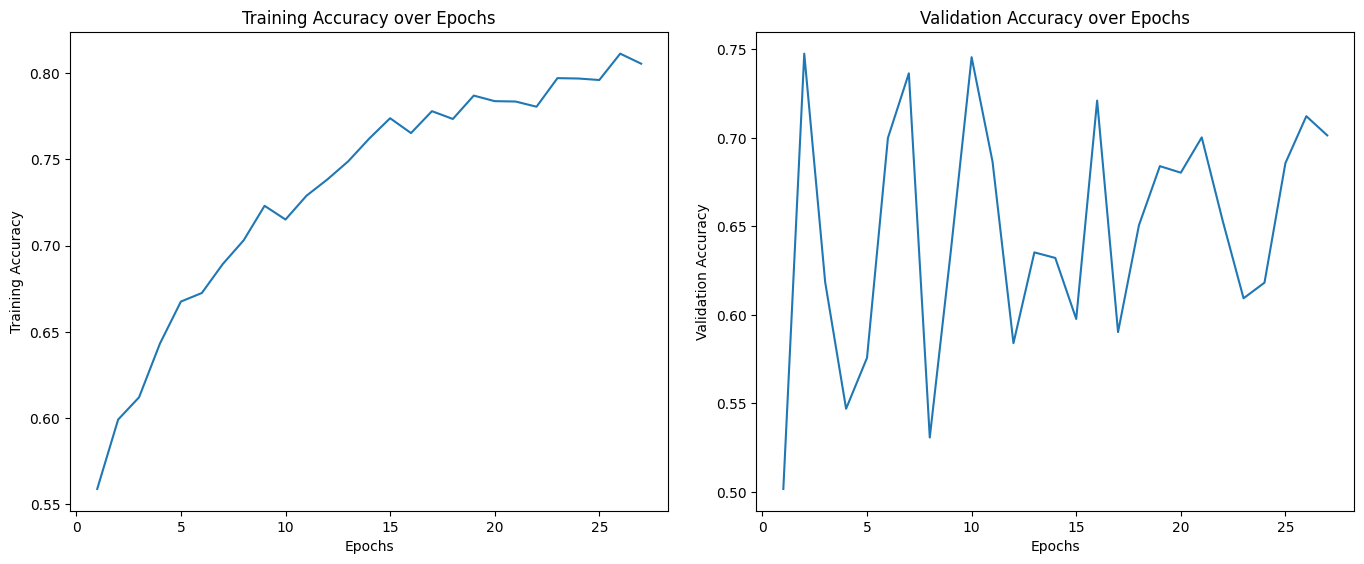

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6)) # (width, height)

# Plotting Training Res on Left
axs[0].plot(range(1, num_eps + 1), train_val_dict['train_accs'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Training Accuracy")
axs[0].set_title("Training Accuracy over Epochs");
axs[0].set
# Plotting Validation Res on Right
axs[1].plot(range(1, num_eps + 1), train_val_dict['val_accs'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Validation Accuracy")
axs[1].set_title("Validation Accuracy over Epochs");
fig.tight_layout(pad = 2); # Spacing between subplots

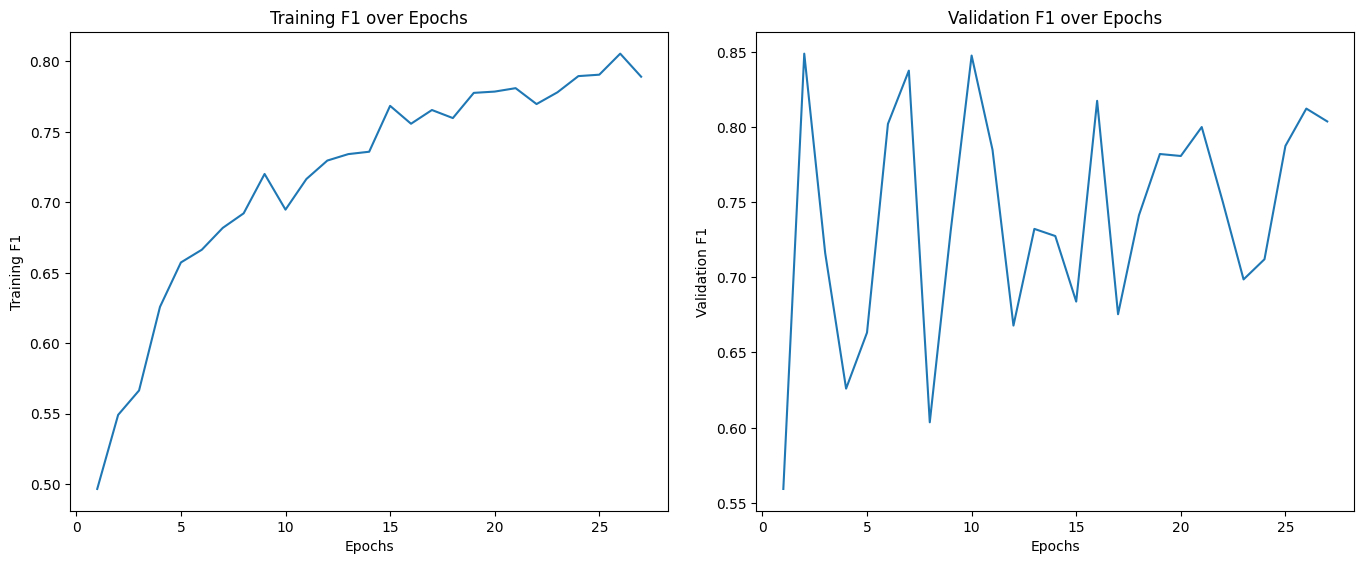

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6)) # (width, height)

# Plotting Training Res on Left
axs[0].plot(range(1, num_eps + 1), train_val_dict['train_f1s'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Training F1")
axs[0].set_title("Training F1 over Epochs");
axs[0].set
# Plotting Validation Res on Right
axs[1].plot(range(1, num_eps + 1), train_val_dict['val_f1s'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Validation F1")
axs[1].set_title("Validation F1 over Epochs");
fig.tight_layout(pad = 2);

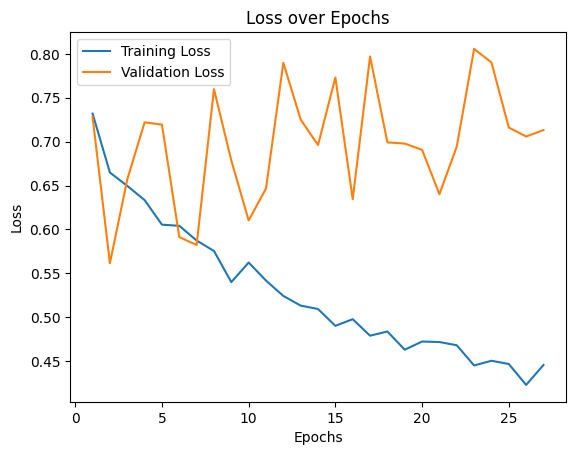

In [51]:
plt.plot(range(1, num_eps + 1), train_val_dict['train_losses'], label = "Training Loss")
plt.plot(range(1, num_eps + 1), train_val_dict['val_losses'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs");

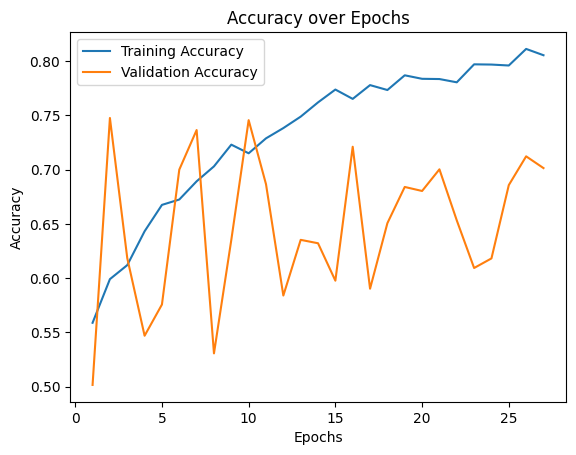

In [52]:
plt.plot(range(1, num_eps + 1), train_val_dict['train_accs'], label = "Training Accuracy")
plt.plot(range(1, num_eps + 1), train_val_dict['val_accs'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs");

In [ ]:
# Validation Accuracy if only assigning Sober Class is 75% and only hovering at that point
# Network is not really learning anything
df_val_mapping['Imp_Sob'].value_counts() / df_val_mapping.shape[0]

S    0.752137
I    0.247863
Name: Imp_Sob, dtype: float64

In [ ]:
# Seems like the model is overtraining on the training dataset, but not having any generalizable aspects for validation dataset
# Train accuracy starts off just guessing Sober and seems to overtrain on itself over time
df_train_mapping['Imp_Sob'].value_counts() / df_train_mapping.shape[0]

S    0.774194
I    0.225806
Name: Imp_Sob, dtype: float64

### Model Training via Cross Validation:

In [ ]:
# Defining dataframe to store results from 3 fold testing on various versions of model
train_res = pd.read_csv("June_7_Network_Results.csv", index_col= 0)
train_res

,epochs,batch_size,LR,avg_train_acc,avg_val_acc,L2,num_layers,num_filters,kernel_sizes
0,27,16,0.001,0.981705,0.841562,True,2,7 & 12,5 & 3
1,27,32,0.001,0.982405,0.823529,True,2,7 & 12,5 & 3


  4%|███                                                                                | 1/27 [00:11<04:52, 11.23s/it]

Epoch 1/27 - Loss: 0.713 - Acc: 0.727
              Val_loss: 0.949 - Val_acc: 0.629


 41%|█████████████████████████████████▍                                                | 11/27 [01:49<02:34,  9.65s/it]

Epoch 11/27 - Loss: 0.177 - Acc: 0.943
              Val_loss: 0.869 - Val_acc: 0.711


 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [03:24<00:56,  9.50s/it]

Epoch 21/27 - Loss: 0.087 - Acc: 0.978
              Val_loss: 0.670 - Val_acc: 0.805


func:'train'  took: 268.2083 sec


  4%|███                                                                                | 1/27 [00:11<05:06, 11.77s/it]

Epoch 1/27 - Loss: 0.789 - Acc: 0.680
              Val_loss: 1.036 - Val_acc: 0.618


 41%|█████████████████████████████████▍                                                | 11/27 [01:49<02:31,  9.49s/it]

Epoch 11/27 - Loss: 0.201 - Acc: 0.933
              Val_loss: 0.819 - Val_acc: 0.735


 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [03:26<00:57,  9.61s/it]

Epoch 21/27 - Loss: 0.105 - Acc: 0.973
              Val_loss: 0.655 - Val_acc: 0.808


func:'train'  took: 266.8811 sec


  4%|███                                                                                | 1/27 [00:13<06:01, 13.90s/it]

Epoch 1/27 - Loss: 0.698 - Acc: 0.721
              Val_loss: 1.078 - Val_acc: 0.609


 41%|█████████████████████████████████▍                                                | 11/27 [01:50<02:34,  9.67s/it]

Epoch 11/27 - Loss: 0.179 - Acc: 0.939
              Val_loss: 0.798 - Val_acc: 0.738


 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [03:29<00:59,  9.87s/it]

Epoch 21/27 - Loss: 0.089 - Acc: 0.976
              Val_loss: 0.707 - Val_acc: 0.788


func:'train'  took: 272.1463 sec
Average train accuracy: 0.9852941176470572
Average validation accuracy: 0.8196778711484582


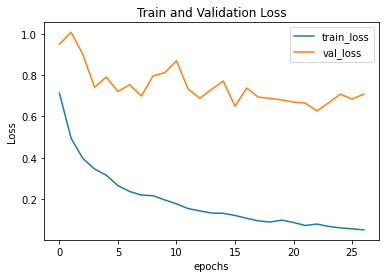

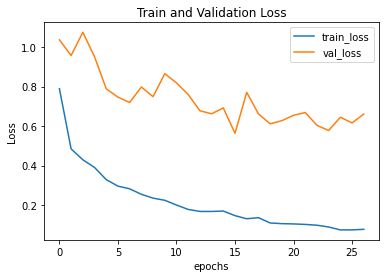

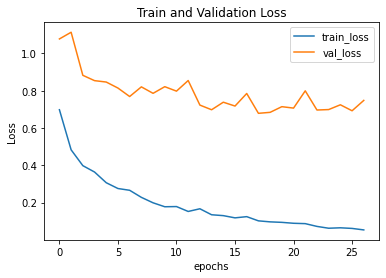

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits= 3, shuffle = True)
# Initializing lists to store values for reporting mean acc and for confusion matrix
train_acc = []
all_test_pred_labels = []
val_acc = []
# Defining parameters tested in this iteration
epochs = 27
batchsize = 32
lr = 1e-3
l2 = True
num_layers = 2
num_filters =  "7 & 12"
kernel_sizes = "5 & 3"
for train_ind, test_ind in kfold.split(X_train, train_y):
        trainfold_X = X_train[train_ind]
        trainfold_y = train_y[train_ind]
        valfold_x = X_train[test_ind]
        valfold_y = train_y[test_ind]
        cnn = CNN().to('mps') # Use .to(torch.device('mps')) to save data and model to GPU
        mlp_trainer = Trainer(cnn, 'adam', 1e-3, epoch= epochs, batch_size= batchsize)
        train_val_dict = mlp_trainer.train(trainfold_X, trainfold_y, valfold_x, valfold_y, early_stop= True, l2= l2,
                                           tens_logger= cnn_logger)
        # Filling train and validation accuracies
        train_acc.append(train_val_dict['accuracies'][-1])
        val_acc.append(max(train_val_dict['val_accuracies']))
        # Plotting Training & Validation Loss
        plt.figure()
        plt.plot(train_val_dict['losses'])
        plt.plot(train_val_dict['val_losses'])
        plt.legend(['train_loss', 'val_loss'])
        plt.title("Train and Validation Loss")
        plt.ylabel('Loss')
        plt.xlabel('epochs');
print('Average train accuracy:', np.mean(train_acc))
print('Average validation accuracy:', np.mean(val_acc))
train_res.loc[len(train_res.index)] = [epochs, batchsize, lr, np.mean(train_acc), np.mean(val_acc), l2,
                                       num_layers, num_filters, kernel_sizes]

In [ ]:
train_res

,epochs,batch_size,LR,avg_train_acc,avg_val_acc,L2,num_layers,num_filters,kernel_sizes
0,27,16,0.001,0.981705,0.841562,True,2,7 & 12,5 & 3
1,27,32,0.001,0.982405,0.823529,True,2,7 & 12,5 & 3
2,27,32,0.001,0.982756,0.817052,True,2,7 & 12,5 & 3
3,27,32,0.001,0.985294,0.819678,True,2,7 & 12,5 & 3


In [ ]:
train_res.sort_values(by = 'avg_val_acc', ascending= False).head(10)

,epochs,batch_size,LR,avg_train_acc,avg_val_acc,L2,num_layers,num_filters,kernel_sizes
0,27,16,0.001,0.981705,0.841562,True,2,7 & 12,5 & 3
1,27,32,0.001,0.982405,0.823529,True,2,7 & 12,5 & 3
3,27,32,0.001,0.985294,0.819678,True,2,7 & 12,5 & 3
2,27,32,0.001,0.982756,0.817052,True,2,7 & 12,5 & 3


In [ ]:
train_res.to_csv("June_7_Network_Results.csv")

## Fully Developed Model

### **Test Dataset Accuracy**

In [118]:
test_ds = Audio_DS(arr_test_specs, test_y, device = "cuda")

In [119]:
test_pred_labels, test_y = mlp_trainer.evaluate(test_ds, val = False)

Test Accuracy: 0.488
Test F1: 0.587


### **Test Dataset Classification Metrics**

### Training Loop Code

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Instantiating Dataset Class
train_ds = Audio_DS(arr_train_specs, train_y, device= "cuda")

# Calculating class weights based on inverse class frequencies
# Class Frequencies
counts_series = df_train_mapping['Imp_Sob'].value_counts()
class_counts = counts_series.values  # Replace with actual class frequencies
sample_weights = [1 / counts_series.loc[class_val] for class_val in df_train_mapping['Imp_Sob']]

# Instantiating WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

# Creating DataLoader with WeightedRandomSampler
batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=32, sampler=sampler)

In [56]:
epochs = 27
batchsize = 32
lr = 1e-3
l2 = True

In [57]:
batch = next(iter(train_dataloader))
print("Batch shape:", batch[0].shape)  # Print the shape of inputs
print("Batch labels:", batch[1])

Batch shape: torch.Size([32, 1, 128, 300])
Batch labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')


In [59]:
import torch.optim as optim
from torchmetrics.classification import BinaryF1Score
model = CNN().to(device)
f1 = BinaryF1Score().to(device)

# Define your lists for storing epoch_acc, epoch_loss
list_epaccs = []
list_eploss = []
list_epf1s = []

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):

  # Initializing epoch metrics
  epoch_loss = 0
  epoch_acc = 0
  epoch_f1 = 0

  for inputs, batch_labels in train_dataloader:

    prop_ds = len(batch_labels) / len(train_ds) # Proportion of Dataset in Batch

    # Zeroing out Gradient to prevent backlog of gradients
    optimizer.zero_grad()
    # Predicting Labels for each class
    batch_logits = model(inputs)
    # Using Cross Entropy Loss
    loss = nn.CrossEntropyLoss()(batch_logits, batch_labels)
    if l2:
      ### Compute the loss with L2 regularization ###
      # Square and sum each entry in each of the arrays and then sum all outputs from all arrays
      loss = loss + 1e-5 * sum([(wei ** 2).sum() for wei in model.parameters()])
    loss.backward() # Batchpropogation of losses through neurons
    optimizer.step() # Updating parameters

    #Updating Loss, Accuracy, F1 on a batch basis since many batchs define an epoch
    epoch_loss += loss.detach().item() * prop_ds
    batch_preds = torch.argmax(batch_logits, axis = -1)
    batch_acc = sum(torch.argmax(batch_logits, dim = 1) == batch_labels) / len(batch_labels)
    batch_f1 = f1(torch.argmax(batch_logits, axis = -1), batch_labels)
    epoch_f1 += batch_f1 * prop_ds
    epoch_acc += batch_acc.detach().item() * prop_ds

  list_epaccs.append(epoch_acc)
  list_eploss.append(epoch_loss)
  list_epf1s.append(epoch_f1)
  print(f"Epoch [{epoch+1}/{epochs}], Loss: {(epoch_loss):.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1.item():.4f} ")

Epoch [1/27], Loss: 0.7223, Acc: 0.5583, F1: 0.5178 
Epoch [2/27], Loss: 0.6695, Acc: 0.6002, F1: 0.5742 
Epoch [3/27], Loss: 0.6613, Acc: 0.6067, F1: 0.5661 
Epoch [4/27], Loss: 0.6561, Acc: 0.6028, F1: 0.5249 
Epoch [5/27], Loss: 0.6311, Acc: 0.6394, F1: 0.6223 
Epoch [6/27], Loss: 0.6274, Acc: 0.6561, F1: 0.6400 
Epoch [7/27], Loss: 0.6184, Acc: 0.6542, F1: 0.6353 
Epoch [8/27], Loss: 0.5942, Acc: 0.6819, F1: 0.6676 
Epoch [9/27], Loss: 0.5751, Acc: 0.6983, F1: 0.6862 
Epoch [10/27], Loss: 0.5720, Acc: 0.7075, F1: 0.6780 
Epoch [11/27], Loss: 0.5489, Acc: 0.7151, F1: 0.7018 
Epoch [12/27], Loss: 0.5813, Acc: 0.6923, F1: 0.6619 
Epoch [13/27], Loss: 0.5185, Acc: 0.7497, F1: 0.7478 
Epoch [14/27], Loss: 0.5423, Acc: 0.7290, F1: 0.7017 
Epoch [15/27], Loss: 0.5075, Acc: 0.7587, F1: 0.7555 
Epoch [16/27], Loss: 0.5332, Acc: 0.7378, F1: 0.7246 
Epoch [17/27], Loss: 0.4902, Acc: 0.7699, F1: 0.7609 
Epoch [18/27], Loss: 0.4930, Acc: 0.7643, F1: 0.7589 
Epoch [19/27], Loss: 0.4854, Acc: 0.7

In [120]:
from sklearn.metrics import confusion_matrix
model_conf = confusion_matrix(y_pred= test_pred_labels, y_true= test_y, labels= [0,1])
model_conf

array([[ 440,  430],
       [1551, 1449]])

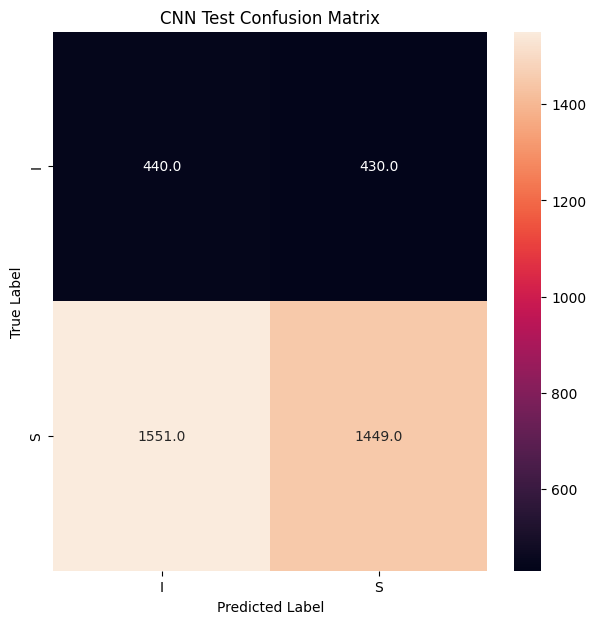

In [121]:
ax = sns.heatmap(model_conf,annot = True, fmt=".1f", xticklabels= dict_labels.keys(), yticklabels= dict_labels.keys())
ax.figure.set_size_inches(7,7)
ax.set_title("CNN Test Confusion Matrix");
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label");

In [122]:
from sklearn.metrics import classification_report
print(classification_report(test_y, test_pred_labels, target_names=dict_labels.keys()))

              precision    recall  f1-score   support

           I       0.22      0.51      0.31       870
           S       0.77      0.48      0.59      3000

    accuracy                           0.49      3870
   macro avg       0.50      0.49      0.45      3870
weighted avg       0.65      0.49      0.53      3870

